In [1]:
# Set parameters
import argparse
parser = argparse.ArgumentParser()

# Data
parser.add_argument(
    '-N_Q', '--N_samples_Q', type=int, default=50, help='total number of target samples',
)
parser.add_argument(
    '-N_P', '--N_samples_P', type=int, default=50, help='total number of prior samples',
)
parser.add_argument(
    '-N_dim', type=int, help='dimension of input data',
)
parser.add_argument(
    '-N_latent_dim', type=int, help='dimension of latent space',
)
parser.add_argument(
    '-N_project_dim', type=int, help='dimension of PCA projected space on input',
)
parser.add_argument(
    '-sample_latent', type=bool, default = False, help='True: sample in the latent space, False: sample in the physical space',
)
# Dataset property
parser.add_argument(
    '--dataset', type=str, default='Learning_gaussian', choices=['Lorenz63', 'Learning_gaussian', 'Mixture_of_gaussians', 'Mixture_of_gaussians2','Mixture_of_gaussians3','Mixture_of_gaussians4', 'Stretched_exponential', 'Learning_student_t', 'Mixture_of_student_t', 'Mixture_of_student_t_submnfld', 'Mixture_of_gaussians_submnfld','MNIST', 'CIFAR10', 'MNIST_switch', 'CIFAR10_switch', 'MNIST_ae', 'MNIST_ae_switch','CIFAR10_ae',  'Mixture_of_gaussians_submnfld_ae','BreastCancer', '1D_pts', '2D_pts','1D_dirac2gaussian', '1D_dirac2uniform',]
)
parser.add_argument(
    '-y0', type=float, nargs="+", default=[1.0,2.0, 2.0]
)
parser.add_argument(
    '-beta', type=float, help='gibbs distribution of -|x|^\beta',
)
parser.add_argument(
    '-sigma_P', type=float, default=0.5, help='std of initial gaussian distribution',
)
parser.add_argument(
    '-sigma_Q', type=float, default=1.0, help='std of target gaussian distribution',
)
parser.add_argument(
    '-nu', type=float, help='df of target student-t distribution',
)
parser.add_argument(
    '-interval_length', type=float, help='interval length of the uniform distribution',
)
parser.add_argument(
    '-label', type=int, nargs="+", help='class label of image data',
)
parser.add_argument(
    '-pts_P', type=float, nargs="+", default=[10.0,]
)
parser.add_argument(
    '-pts_Q', type=float, nargs="+", default=[0.0,]
)
parser.add_argument(
    '-pts_P_2', type=float, nargs="+", default=[0.0,]
)
parser.add_argument(
    '-pts_Q_2', type=float, nargs="+", default=[0.0,]
)
parser.add_argument(
    '--random_seed', type=int, default=0, help='random seed for data generator',
)


# (f, Gamma)-divergence
parser.add_argument(
    '--f', type=str, default='KL', choices=['KL', 'alpha', 'reverse_KL', 'JS'],
)
parser.add_argument(
    '-alpha', type=float, help='parameter value for alpha divergence',
)    
parser.add_argument(
    '--formulation', type=str, default='DV', choices=['LT', 'DV'], help='LT or DV in case of f=KL, otherwise, keep LT',
)
parser.add_argument(
    '--Gamma', type=str, default='Lipshitz', choices=['Lipshitz'],
)
parser.add_argument(
    '-L', type=float, default=1.0, help='Lipshitz constant: default=inf w/o constraint',
)
parser.add_argument(
    '--reverse', type=bool, default=False, help='True -> D(Q|P), False -> D(P|Q)',
)
parser.add_argument(
    '--constraint', type=str, default='hard', choices=['hard', 'soft'],
)
parser.add_argument(
    '-lamda', type=float, default=20.0, help='coefficient on soft constraint',
)


# RKHS definition <phi>
parser.add_argument(
    '--kernel', type=str, default='gaussian', choices=['gaussian'],
)
parser.add_argument(
    '-bandwidth', type=float, default = 20.0, help='gaussian kernel bandwidth',
)


# training parameters
parser.add_argument(
    '-ep', '--epochs', type=int, default=1000, help='# updates for P',
)
parser.add_argument(
    '-ep_phi', '--epochs_phi', type=int, default=5, help='# updates to find phi*',
)
parser.add_argument(
    '--optimizer', type=str, choices=['Newton', 'BFGS','Gradient_Ascent'], default='BFGS', help='optimization method for phi',
)
parser.add_argument(
    '--ode_solver', type=str, choices=['forward_euler', 'AB2', 'AB3', 'AB4', 'AB5', 'ABM1', 'Heun', 'ABM2', 'ABM3', 'ABM4', 'ABM5', 'RK4', 'ode45' ], default='forward_euler', help='ode solver for particle ode',
)
parser.add_argument(
    '-mobility', type=str, help='problem dependent mobility function\nRecommendation: MNIST - bounded',
)
parser.add_argument(
    '-lr_P_decay', type=str, choices=['rational', 'step',], help='delta t decay',
)
parser.add_argument(
    '--lr_P', type=float, default=20.0, help='lr for P',
)
parser.add_argument(
    '--lr_phi', type=float, default=0.2, help='lr for phi',
)
parser.add_argument(
    '--exp_no', type=str, default='rkhs', help='short experiment name under the same data',
)
parser.add_argument(
    '--mb_size_P', type=int, default=50, help='mini batch size for the moving distribution P',
)
parser.add_argument(
    '--mb_size_Q', type=int, default=50, help='mini batch size for the target distribution Q',
)


# save/display 
parser.add_argument(
    '--save_iter', type=int, default=10, help='save results per each save_iter',
)
parser.add_argument(
    '--plot_result', type=bool, default=True, help='True -> show plots',
)
parser.add_argument(
    '--plot_intermediate_result', type=bool, default=False, help='True -> save intermediate plots',
)

_StoreAction(option_strings=['--plot_intermediate_result'], dest='plot_intermediate_result', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, required=False, help='True -> save intermediate plots', metavar=None)

In [2]:
import os
import numpy as np
import re
from functools import partial

In [3]:
# input parameters --------------------------------------
p, unknown = parser.parse_known_args()
param = vars(p)

if p.alpha:    
    par = [p.alpha]
    p.exptype = '%s=%05.2f-%s' % (p.f, p.alpha, p.Gamma)
else: 
    par = []
    p.exptype = '%s-%s' % (p.f, p.Gamma)
if p.L == None:
    p.expname = '%s_%s' % (p.exptype, 'inf')
else:
    p.expname = '%s_%.4f' % (p.exptype, p.L)

In [4]:
from util.generate_data import generate_data
# X_ ~ Q, Y_ ~ P_0
p, X_, Y_, X_label, Y_label = generate_data(p)

In [5]:
# Discriminator learning  -----------------------------------------
# kernel for RKHS
def gaussian_kernel(x, y, bandwidth):
    return np.exp(-np.sum(((x-y)/bandwidth)**2)/2)
    
def kernel(X_, Y_, bandwidth=1):
    res = np.zeros((X_.shape[0],Y_.shape[0]))
    for i, x in enumerate(X_):
        for j, y in enumerate(Y_):
            res[i,j] = gaussian_kernel(x, y, bandwidth=bandwidth)
    return res
    
k = partial(kernel, bandwidth=p.bandwidth)

In [6]:
# (Discriminator) Loss
if p.f == "KL":
    f = lambda x: x * np.log(x)
    f_prime = lambda x: np.log(x) + 1
    f_2prime = lambda x: 1/x
    f_star = lambda x: np.exp(x - 1)
elif p.f == 'alpha':
    f = lambda x: (x**p.alpha - 1)/(p.alpha*(p.alpha-1))
    f_prime = lambda x: x**(p.alpha-1)/(p.alpha-1)
    f_2prime = lambda x: x**(p.alpha-2)
    f_star = lambda x: 1/p.alpha*(1/(p.alpha-1) + ((p.alpha-1)*np.maximum(x,0))**(p.alpha/(p.alpha-1)))
    
def loss(X_, Y_, alpha, lamda):
# loss = \sum_i alpha_i f'(n*alpha_i) - \sum_i f^*(f'(n*alpha_i))/n +
#        1/2* (\sum_i \sum_j k(Y_i, Y_j)/n^2 - 2/n* alpha_i * k(X_i, Y_j) + alpha_i*alpha_j * k(X_i, X_j)
    n = X_.shape[0]
    return np.dot(alpha, f_prime(n*alpha)) -np.sum(f_star(f_prime(n*alpha)))/n + 1/(2*lamda) * (np.sum((k(Y_, Y_)/n**2 + np.dot(k(X_,X_), np.outer(alpha,alpha))).flatten()) - 2/n*np.sum(k(Y_, X_)@alpha))
    
def grad_loss(X_, Y_, alpha, print_component_norms=False):
    n = X_.shape[0]
    K_XY = np.round(np.linalg.norm(np.sum(k(X_, Y_), axis=1)/(n*p.lamda)), 4)
    K_XX = np.round(np.linalg.norm(k(X_, X_) @ alpha/(2*p.lamda)), 4)
    f_prime_n_alpha = np.round(np.linalg.norm(f_prime(n*alpha)), 4)
    if print_component_norms == True:
        print(r"gradient loss: norm of $K_{XY}, K_{XX}, f'(n \alpha)$ :", K_XY, K_XX, f_prime_n_alpha)
    return f_prime(n*alpha) - np.sum(k(X_, Y_), axis=1)/(n*p.lamda) + k(X_, X_) @ alpha/(2*p.lamda)
    
def hess_loss(X_, Y_, alpha):
    n = X_.shape[0]
    return np.diag(n*f_2prime(n*alpha)) + k(X_, X_)/(2*p.lamda)
    
def Newton(alpha, lr_phi, grad, hess):
    #print(np.linalg.eigvals(np.linalg.inv(hess_loss(X_, Y_, alpha))))
    return alpha - lr_phi*np.linalg.inv(hess) @ grad
    
def BFGS(alpha, lr_phi, grad, B_inv, X_, Y_):
    p_k = - B_inv @ grad
    s_k = lr_phi * p_k
    alpha = alpha + s_k
    y_k = grad_loss(X_, Y_, alpha) - grad
    B_inv += (np.dot(s_k, y_k) + np.sum((B_inv * np.outer(y_k, y_k)).flatten()))/np.dot(s_k, y_k)**2 * np.outer(s_k, s_k) - (B_inv @ np.outer(y_k, s_k.T) + np.outer(s_k, y_k) @ B_inv)/np.dot(s_k, y_k)
    return alpha, B_inv

In [7]:
# Transporting particles --------------------------------------------
# gradient of first variation
def grad_gaussian_kernel(x, y, bandwidth):
# gradient with respect to first argument (x) of gaussian kernel k(x,y)
    return - (x-y)/bandwidth**2 * gaussian_kernel(x,y,bandwidth)
    
def grad_kernel(X_, Y_, bandwidth):
    res = np.zeros((X_.shape[0], Y_.shape[1], Y_.shape[0]))
    for i, x in enumerate(X_):
        for j, y in enumerate(Y_):
            res[i,:,j] = grad_gaussian_kernel(x, y, bandwidth)
    return res

grad_k = partial(grad_kernel, bandwidth=p.bandwidth)
    
def grad_loss_first_variation(y, X_, Y_, alpha, lamda):
    n = X_.shape[0]
    return 1/lamda * (1/n * np.sum(grad_k(y, Y_), axis=2) - grad_k(y, X_) @ alpha)

In [8]:
# ODE solver setting
#from util.transport_particles import calc_vectorfield, solve_ode
dPs = []
if p.ode_solver in ['forward_euler', 'AB2', 'AB3', 'AB4', 'AB5']:
    aux_params = []
else:
    aux_params = {'parameters': parameters, 'phi': phi, 'Q': Q, 'lr_phi': lr_phi,'epochs_nn': p.epochs_nn, 'loss_par': loss_par, 'NN_par': NN_par, 'data_par': data_par, 'optimizer': p.optimizer}

# Applying mobility to particles
#if p.mobility == 'bounded':
#    from util.construct_NN import bounded_relu  # mobility that bounding particles (For image data)
        
# Train setting
lr_P_init = p.lr_P # Assume that deltat = deltat(t)
if p.ode_solver == "DOPRI5": # deltat = deltat(x,t)
    lr_P_init = [p.lr_P]*p.N_samples_P
    # Low dimensional example=> rank 2, Image example=> rank 4
    for i in range(1, Y_.ndim):
        lr_P_init = np.expand_dims(lr_P_init, axis=i)
lr_P = lr_P_init
lr_Ps = []

In [9]:
# Save & plot settings -----------------------------------------------
# Metrics to calculate
from util.evaluate_metric import calc_ke, calc_grad_phi
if "MNIST" in p.dataset or "CIFAR10" in p.dataset:
    from util.evaluate_metric import calc_fid
trajectories = []
vectorfields = []
divergences = []
KE_Ps = []
FIDs = []

# saving/plotting parameters
if p.save_iter >= p.epochs:
    p.save_iter = 1

if p.plot_result == True:
    from plot_result import plot_result

p.expname = p.expname+'_%04d_%04d_%02d_%s' % (p.N_samples_Q, p.N_samples_P, p.random_seed, p.exp_no)
filename = p.dataset+'/%s.pickle' % (p.expname)

if p.plot_intermediate_result == True:
    if 'gaussian' in p.dataset and 'Extension' not in p.dataset:
         r_param = p.sigma_Q
    elif 'student_t' in p.dataset:
        r_param = p.nu
    elif p.dataset == 'Extension_of_gaussian':
        r_param = p.a
    else:
        r_param = None
    
# additional plots for simple low dimensional dynamics
if p.N_dim == 1:
    xx = np.linspace(-10, 10, 300)
    phis = []
elif p.N_dim == 2:#'2D' in p.dataset:
    xx = np.linspace(-10, 10, 40)
    yy = np.linspace(-10, 10, 40)
    XX, YY = np.meshgrid(xx, yy)
    xx = np.concatenate((np.reshape(XX, (-1,1)), np.reshape(YY, (-1,1))), axis=1)
    phis = []
    

In [10]:
# Train ---------------------------------------------------------------
import time 
t0 = time.time()

alpha = np.ones(p.N_samples_P)
for it in range(1, p.epochs+1): # Loop for updating particles P
    for in_it in range(p.epochs_phi):
        grad = grad_loss(X_, Y_, alpha, print_component_norms=False)
        if p.optimizer == 'Newton':
            hess = hess_loss(X_, Y_, alpha)
            alpha = Newton(alpha, p.lr_phi, grad, hess)
        elif p.optimizer == 'BFGS':
            if in_it == 0:
                hess = hess_loss(X_, Y_, alpha)
                B_inv = np.linalg.inv(hess)
                alpha, B_inv = BFGS(alpha, p.lr_phi, grad, B_inv, X_, Y_)
    current_loss = loss(X_, Y_, alpha, p.lamda)
            
    dP = grad_loss_first_variation(Y_, X_, Y_, alpha, p.lamda)
    dPs.append(dP)
    
    Y_ = Y_ - lr_P * dPs[-1]
    '''
    if p.ode_solver == "DOPRI5": # deltat adust
        P, dPs, dP, lr_P = solve_ode(P, lr_P, dPs, p.ode_solver, aux_params) # update P
    else:
        P, dPs, dP = solve_ode(P, lr_P, dPs, p.ode_solver, aux_params) # update P
    '''

    if p.mobility == 'bounded':
        Y_ = bounded_relu(Y_)
     
    lr_Ps.append(lr_P)
    # adjust learning rates
    #if it>=100:
    #    lr_P = decay_learning_rate(lr_P, p.lr_P_decay, {'epochs': p.epochs-100, 'epoch': it-100, 'KE_P': KE_P})
    
    # save results
    divergences.append(current_loss)
    KE_P = calc_ke(dP, p.N_samples_P)
    KE_Ps.append(KE_P)
    grad_phi = calc_grad_phi(dP)
    #print("grad", grad_phi)
    
    if p.epochs<=100 or it%p.save_iter == 0:
        if p.dataset in ['BreastCancer',]:
            trajectories.append(Y_*10)
        else:
            trajectories.append(Y_)
        if np.prod(p.N_dim) < 500:
            vectorfields.append(dP)
        elif np.prod(p.N_dim) >= 784:  # image data
            FIDs.append( calc_fid(pred=Y_, real=X_) )
    
    # display intermediate results
    if it % (p.epochs/10) == 0:
    #if it in [5, 50, 500, 1000, 2000, 3000, 4000, 5000]:
        display_msg = 'iter %6d: loss = %.10f, kinetic energy of P = %.10f, average learning rate for P = %.6f' % (it, current_loss, KE_P, np.mean(lr_P))
        if np.prod(p.N_dim) >= 784:
            display_msg = display_msg + ', FID = %.3f' % FIDs[-1]
        print(display_msg)
        print("grad", grad_phi)
        
        if p.plot_intermediate_result == True:
            data = {'trajectories': trajectories, 'divergences': divergences, 'KE_Ps': KE_Ps, 'FIDs':FIDs, 'X_':X_, 'Y_':Y_, 'X_label':X_label, 'Y_label':Y_label, 'dt': lr_Ps, 'dataset': p.dataset, 'r_param': r_param, 'vectorfields': vectorfields, 'save_iter':p.save_iter}
            if p.N_dim ==2:
                data.update({'phi': phi, 'W':W, 'b':b, 'NN_par':NN_par})
            plot_result(filename, intermediate=True, epochs = it, iter_nos = None, data = data, show=False)
        
        '''
        if np.prod(p.N_dim) <= 2:
            zz = phi(xx,None, W,b,NN_par).numpy()
            zz = np.reshape(zz, -1)
            phis.append(zz)
        '''

total_time = time.time() - t0
print(f'total time {total_time:.3f}s')

iter    100: loss = -0.1791613800, kinetic energy of P = 0.0000001194, average learning rate for P = 20.000000
grad 0.00047790933919903604
iter    200: loss = -0.1792512903, kinetic energy of P = 0.0000001115, average learning rate for P = 20.000000
grad 0.00045684930195082226
iter    300: loss = -0.1793608929, kinetic energy of P = 0.0000001047, average learning rate for P = 20.000000
grad 0.00043634707108923114
iter    400: loss = -0.1794978681, kinetic energy of P = 0.0000000997, average learning rate for P = 20.000000
grad 0.0004205760997357137
iter    500: loss = -0.1796714762, kinetic energy of P = 0.0000000967, average learning rate for P = 20.000000
grad 0.00040951572015939615
iter    600: loss = -0.1798922875, kinetic energy of P = 0.0000000962, average learning rate for P = 20.000000
grad 0.0004037679383525995
iter    700: loss = -0.1801714601, kinetic energy of P = 0.0000000979, average learning rate for P = 20.000000
grad 0.00040453715033702197
iter    800: loss = -0.180519

Results saved at: Learning_gaussian/KL-Lipshitz_1.0000_1.00_0050_0050_00_rkhs.pickle


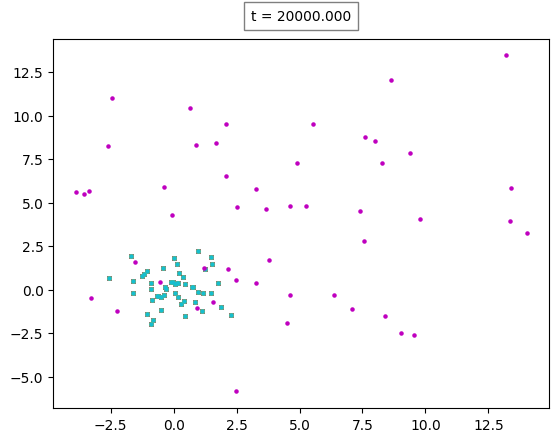

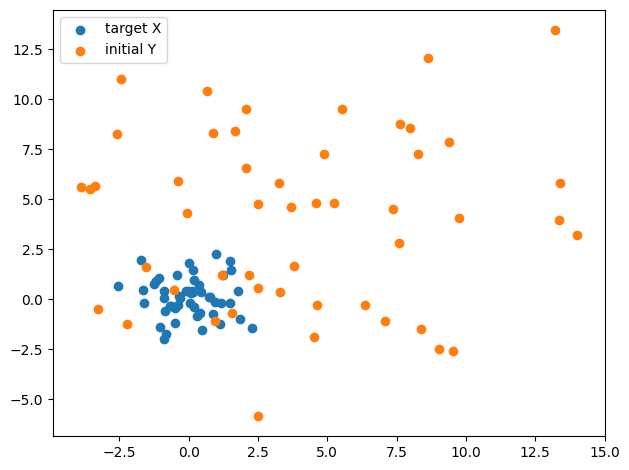

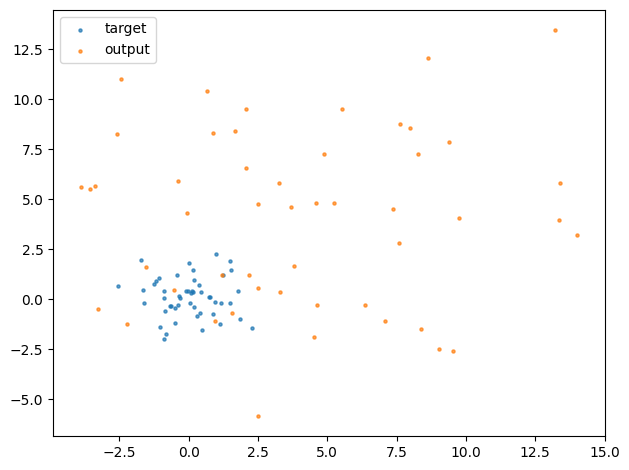

plot_trajectories


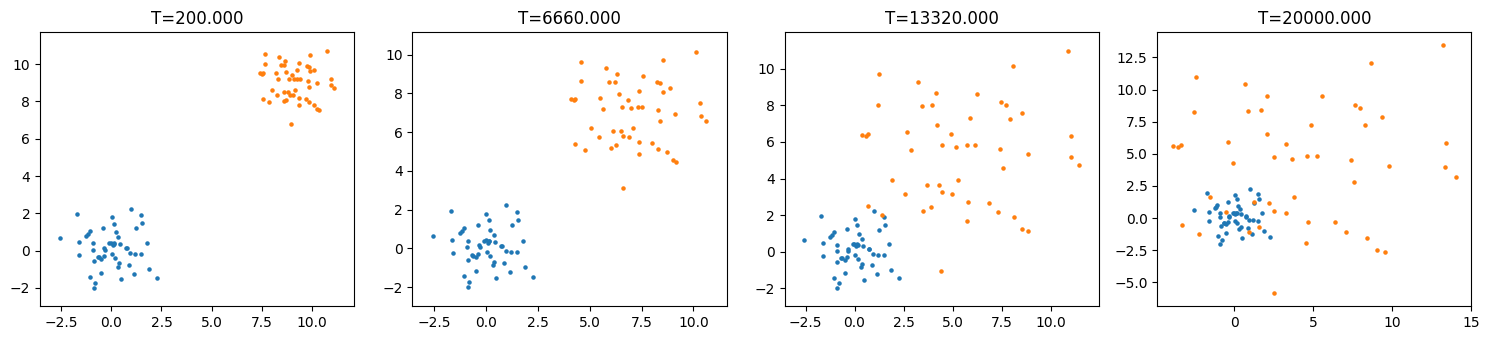

plot divergences
Last: divergences = -0.181448


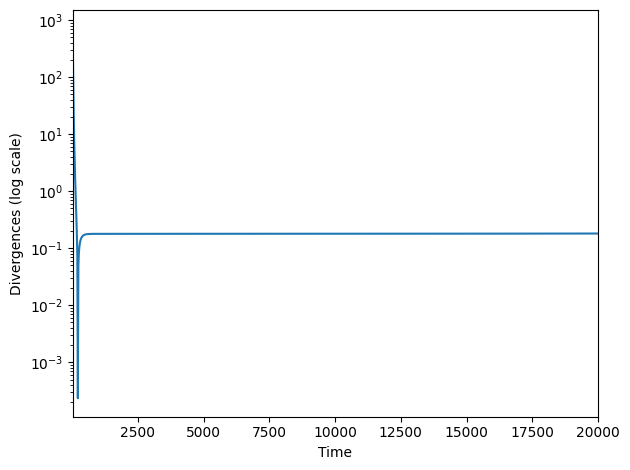

plot KE_Ps
Last: KE_Ps = 0.000000


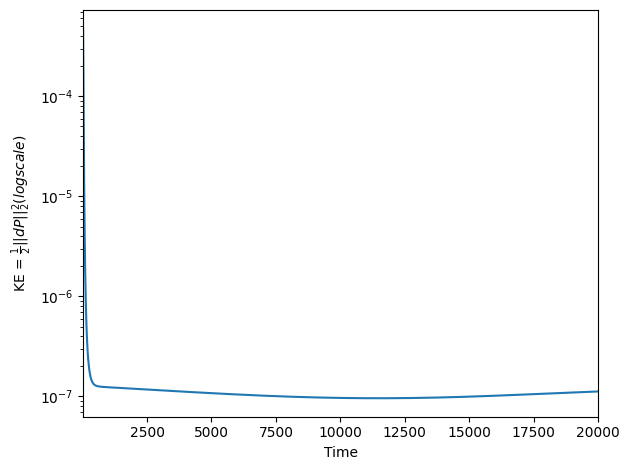

UnboundLocalError: local variable 'phi' referenced before assignment

In [11]:
# Save result ------------------------------------------------------
import pickle
if not os.path.exists(p.dataset):
    os.makedirs(p.dataset)

if '1D' in p.dataset:
    X_ = np.concatenate((X_, np.zeros(shape=X_.shape)), axis=1)
    Y_ = np.concatenate((Y_, np.zeros(shape=Y_.shape)), axis=1)
    
    trajectories = [np.concatenate((x, np.zeros(shape=x.shape)), axis=1) for x in trajectories]
    vectorfields = [np.concatenate((x, np.zeros(shape=x.shape)), axis=1) for x in vectorfields]
        
param.update({'X_': X_, 'Y_': Y_, 'lr_Ps':lr_Ps,})
result = {'trajectories': trajectories, 'vectorfields': vectorfields, 'divergences': divergences, 'KE_Ps': KE_Ps, 'FIDs': FIDs,}

if p.dataset in ['BreastCancer',]:
    np.savetxt("gene_expression_example/GPL570/"+p.dataset+'/output_norm_dataset_dim_%d.csv' % p.N_dim, trajectories[-1], delimiter=",")
        
# Save trained data
with open(filename,"wb") as fw:
    pickle.dump([param, result] , fw)
print("Results saved at:", filename)

# Plot final result
if p.plot_result == True:
    plot_result(filename, intermediate=False, show=True)
